# Download Data

In [ ]:
import logging
# Create a logger object
log = logging.getLogger(__name__)

# Configure logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(filename)s - %(funcName)s - %(lineno)d - %(message)s')


In [ ]:
import pathlib
dirs = [
    './data/midi_files',
    './data/training_data',
    './data/training_data/reconstructed_midi',
    './samples',
    './checkpoints/lstm_vae',
]

for dir in dirs:
  pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

In [ ]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


# Train

In [ ]:
from torch import autograd, nn, optim
from torchvision.utils import save_image
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn.functional as F


Some utility functions

In [ ]:
def duplicate(x, rep):
    return x.expand(rep, *x.shape).reshape(-1, *x.shape[1:])

def save_model_by_name(model, global_step):
    save_dir = os.path.join("checkpoints", model.name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    file_path = os.path.join(save_dir, "model-{:05d}.pt".format(global_step))
    state = model.state_dict()
    torch.save(state, file_path)
    print("Saved to {}".format(file_path))

def reset_weights(m):
    try:
        m.reset_parameters()
    except AttributeError:
        pass

def sample_gaussian(m, v):
    z = torch.randn_like(m) * torch.sqrt(v) + m
    return z

def kl_normal(qm, qv, pm, pv):
    element_wise = 0.5 * (
         torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1
    )
    kl = element_wise.sum(-1)
    return kl

Data Loader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle

seq_len = 32

class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        x = torch.tensor(sequence, dtype=torch.float32)  # Only Input sequence
        return x


def get_data_loader(file_path, batch_size=4, shuffle=True):
    with open(file_path, "rb") as file:
        sequences = pickle.load(file)

    dataset = SequenceDataset(sequences)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Create the DataLoader
dataloader = get_data_loader(
    "./drive/MyDrive/Colab Notebooks/32_note_sequences_filtered.pkl", batch_size=1024, shuffle=True
)

total_data_items = len(dataloader.dataset)  # or len(dataloader.sampler) if a subset is used

print("Total number of data items:", total_data_items)

dataiter = iter(dataloader)
data = next(dataiter)
print("Shape of each data:", data[0].shape)

poly_dataloader = get_data_loader(
    "./drive/MyDrive/Colab Notebooks/polyphonic_data_piano_vqvae.pkl", batch_size=1024, shuffle=True
)
poly_dataiter = iter(poly_dataloader)
poly_data = next(poly_dataiter)
print("Shape of each poly data:", poly_data[0].shape)

Total number of data items: 19162
Shape of each data: torch.Size([32, 129])
Shape of each poly data: torch.Size([64, 4, 88])


# GAN

In [ ]:
latent_dim = 64

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        output = self.sigmoid(self.fc(attn_out)) * 128 + 1
        return output

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # print(lstm_out.shape)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        # print(attn_out.shape)
        output = self.fc(attn_out)  # Use the last sequence output
        return output

In [ ]:
# Assuming Generator and Discriminator classes are defined as per your requirements
hidden_dim = 1024
output_dim = seq_len
num_layers = 2
num_heads = 4

In [ ]:
import torch.nn.utils as utils
import matplotlib.pyplot as plt
# def to_one_hot(tensor):
#     max_indices = torch.argmax(tensor, dim=-2)
#     one_hot = torch.nn.functional.one_hot(max_indices, num_classes=tensor.shape[2])
#     return one_hot.float()
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(g_learning_rate, d_learning_rate, dataloader=dataloader, clip_value = 0.01, num_epochs=20):

    g_losses = []
    d_losses = []

    # Initialize generator and discriminator
    generator = Generator(
        input_dim=latent_dim,
        hidden_dim=hidden_dim*2,
        output_dim=output_dim,
        num_layers=num_layers*2,
        num_heads=num_heads*2)
    discriminator = Discriminator(
        input_dim=seq_len,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_heads=num_heads)
    def print_grad_hook(module, grad_input, grad_output):
      pass

    for layer in generator.modules():
        layer.register_backward_hook(print_grad_hook)
    # Loss function
    bce_logit_loss = nn.BCEWithLogitsLoss()
    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), g_learning_rate, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), d_learning_rate, betas=(0.5, 0.999))

    generator.to(device)
    discriminator.to(device)
    bce_logit_loss.to(device)

    def d_loss(real_data, i):
      valid = torch.ones((real_data.size(0), 1), device=device)
      fake = torch.zeros((real_data.size(0), 1), device=device)
      z = torch.randn(real_data.size(0), latent_dim, device=device, requires_grad=True)
      gen_data = generator(z)
      # print(real_data.shape)
      # bce_loss default reduction is mean
      d_r = discriminator(real_data)
      d_g = discriminator(gen_data)
      return d_r.mean() - d_g.mean()

    def g_loss(batch_size):
      valid = torch.ones((batch_size, 1), device=device)
      z = torch.randn(batch_size, latent_dim, device=device, requires_grad=True)

      gen_data = generator(z)
      g_loss = -discriminator(gen_data)
      return g_loss.mean()

    for epoch in range(num_epochs):
        for i, real_data in enumerate(dataloader):
            # real_data is of shape [batch, 64, 129]

            real_data_label = torch.argmax(real_data, dim=-1).float().to(device)
            real_data_label = real_data_label.view(real_data_label.shape[0], -1)
            batch_size = real_data.size(0)

            optimizer_D.zero_grad()
            d_l = d_loss(real_data_label, i)
            d_losses.append(d_l.item())
            # Clip weights of discriminator
            d_l.backward()
            optimizer_D.step()
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            optimizer_G.zero_grad()
            g_l = g_loss(batch_size)
            g_losses.append(g_l.item())
            g_l.backward()

            for p in generator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            optimizer_G.step()


            if i % 10 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}] [D loss: {d_l.item()}] [G loss: {g_l.item()}]")

    plt.plot(g_losses, label = f"g_loss_{g_learning_rate}")
    plt.plot(d_losses, label = f"d_learning_rate {d_learning_rate}")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()
    plt.show()

    return generator, discriminator

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1349: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full back

[Epoch 0/20] [Batch 0] [D loss: 0.0005401559174060822] [G loss: 0.01805667206645012]
[Epoch 0/20] [Batch 10] [D loss: -1163.3028564453125] [G loss: -562.9400024414062]
[Epoch 1/20] [Batch 0] [D loss: 0.11052358150482178] [G loss: 1.1618890762329102]
[Epoch 1/20] [Batch 10] [D loss: -0.259857714176178] [G loss: 0.7182719707489014]
[Epoch 2/20] [Batch 0] [D loss: 1.0699970722198486] [G loss: -0.0478992834687233]
[Epoch 2/20] [Batch 10] [D loss: -2.1429553031921387] [G loss: -0.675132155418396]
[Epoch 3/20] [Batch 0] [D loss: -2.9548392295837402] [G loss: 3.145146369934082]
[Epoch 3/20] [Batch 10] [D loss: -169.0009765625] [G loss: 577.9498291015625]
[Epoch 4/20] [Batch 0] [D loss: -881.1881713867188] [G loss: -312.8342590332031]
[Epoch 4/20] [Batch 10] [D loss: -995.1864624023438] [G loss: -481.3045959472656]
[Epoch 5/20] [Batch 0] [D loss: -1514.32861328125] [G loss: -755.7755737304688]
[Epoch 5/20] [Batch 10] [D loss: -730.7320556640625] [G loss: -129.7252960205078]
[Epoch 6/20] [Batch

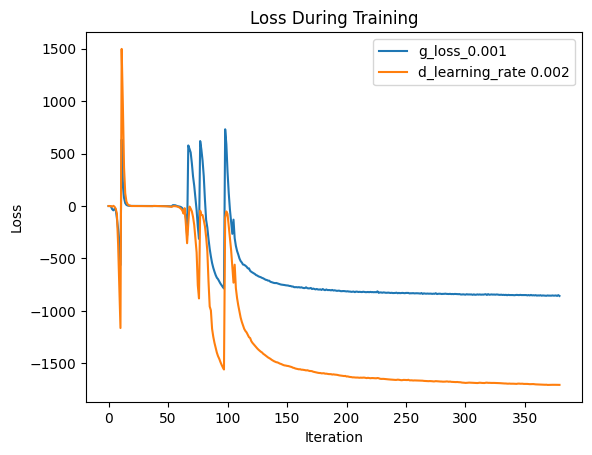

In [ ]:
generator, discriminator = train(g_learning_rate=1e-3, d_learning_rate=2e-3)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1324: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1349: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full back

[Epoch 0/100] [Batch 0] [D loss: -0.0003374171210452914] [G loss: -0.00046147897955961525]
[Epoch 1/100] [Batch 0] [D loss: -0.001646299147978425] [G loss: -0.004102637991309166]
[Epoch 2/100] [Batch 0] [D loss: -0.013810202479362488] [G loss: -0.010201084427535534]
[Epoch 3/100] [Batch 0] [D loss: -0.11040351539850235] [G loss: 0.4551284909248352]
[Epoch 4/100] [Batch 0] [D loss: -1.193878173828125] [G loss: -1.451712727546692]
[Epoch 5/100] [Batch 0] [D loss: -14.481773376464844] [G loss: -5.985207557678223]
[Epoch 6/100] [Batch 0] [D loss: -21.412803649902344] [G loss: 57.673831939697266]
[Epoch 7/100] [Batch 0] [D loss: -0.15425491333007812] [G loss: 60.521846771240234]
[Epoch 8/100] [Batch 0] [D loss: -2.934661865234375] [G loss: 7.545854091644287]
[Epoch 9/100] [Batch 0] [D loss: -1.3300752639770508] [G loss: 33.21812057495117]
[Epoch 10/100] [Batch 0] [D loss: -6.900058746337891] [G loss: 80.83372497558594]
[Epoch 11/100] [Batch 0] [D loss: -1.2417755126953125] [G loss: 84.90193

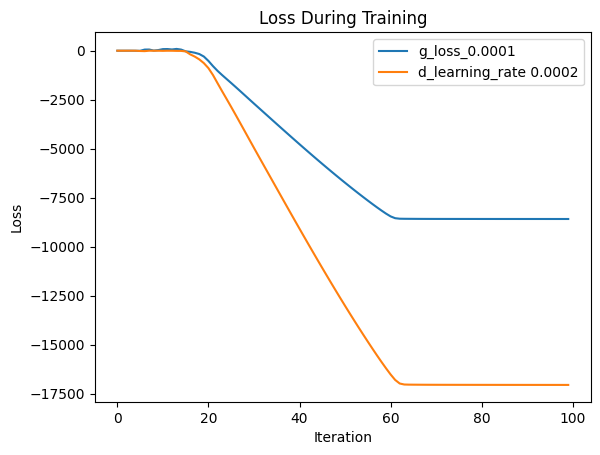

In [ ]:
seq_len = 256
hidden_dim = 2048
output_dim = seq_len
num_layers = 4
num_heads = 4

# generator, discriminator = train(g_learning_rate=1e-4, d_learning_rate=2e-4, dataloader=poly_dataloader, clip_value = 0.01, num_epochs=100)

In [ ]:
def convert_to_one_hot(labels, num_classes):
    labels = torch.round(labels).to(torch.int64)

    flat_labels = labels.view(-1)  # Shape: [batch * 32]
    one_hot_flat = F.one_hot(flat_labels, num_classes=num_classes)

    # Reshape back to [batch, 32, num_classes]
    one_hot = one_hot_flat.view(*labels.shape, num_classes)
    return one_hot

! pip install pretty_midi
import pretty_midi

def reconstruct_midi_from_multihot_seq(
    seq, output_midi_path, sixteenth_note_duration=0.15
):
    """
    Reconstruct a MIDI file from a multi-hot encoded sequence.

    :param seq: A numpy array of shape [seq_len, 88] representing the multi-hot encoded sequence.
    :param output_midi_path: Path where the reconstructed MIDI file will be saved.
    :param sixteenth_note_duration: Duration of a sixteenth note in seconds.
    """
    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program("Acoustic Grand Piano")
    piano = pretty_midi.Instrument(program=piano_program)

    for time_step in range(seq.shape[0]):  # For each timestep (256)
        for note in range(seq.shape[1]):  # For each note in the timestep (88)
            if seq[time_step, note] == 1:
                # Calculate the start and end times of the note
                start_time = time_step * sixteenth_note_duration
                end_time = start_time + sixteenth_note_duration

                # Create a Note object and add it to the piano instrument
                midi_note = pretty_midi.Note(
                    velocity=100,  # Adjust the velocity if needed
                    pitch=note + 21,  # Offset by 21 to match the MIDI pitch
                    start=start_time,
                    end=end_time,
                )
                piano.notes.append(midi_note)

    # Add the piano instrument to the PrettyMIDI object
    midi.instruments.append(piano)

    # Write out the MIDI data to the output file
    midi.write(output_midi_path)

def convert_to_multi_hot(labels, group = 4):
    labels = torch.round(labels).to(torch.int64)
    labels = labels.view(-1,4)
    multi_hot_tensor = torch.zeros(64, 88, dtype=torch.int)
    # Iterate through each row and column in the original tensor
    for i in range(labels.shape[0]):
      for j in range(labels.shape[1]):
        # Set the corresponding index in the multi-hot tensor to 1
        idx = labels[i, j]
        multi_hot_tensor[i, idx] = 1
    return multi_hot_tensor


num_samples = 1 # num of measures
noise = torch.randn(num_samples, latent_dim).to(device)
generator.eval()

with torch.no_grad():
    gen_data = generator(noise).view(1, -1)
    print(gen_data)
    generated_samples = convert_to_multi_hot(gen_data, 4)
    reconstruct_midi_from_multihot_seq(generated_samples.detach(), "./samples/sample.mid", 0.5)
    # reconstruct_midi_from_vectors(generated_samples.detach().tolist(), "./samples/sample.mid", 0.20)

tensor([[66.7503, 62.7334, 64.0923, 63.5546, 66.2429, 62.0735, 66.9547, 62.7279,
         67.2598, 64.3765, 65.7589, 66.4545, 67.0734, 63.0185, 63.1048, 66.3514,
         66.1070, 66.5949, 67.2669, 66.6134, 62.5315, 63.9309, 66.8063, 63.6896,
         63.9391, 66.8156, 63.4590, 66.8839, 63.2479, 63.2627, 66.0853, 63.5625,
         63.1265, 61.9531, 66.5346, 66.3667, 63.7738, 62.5898, 63.4038, 66.5332,
         68.0265, 67.0194, 66.3097, 66.5249, 66.3531, 63.6391, 67.8008, 65.8258,
         62.7805, 67.0138, 65.9971, 66.5871, 63.5806, 62.7562, 63.8433, 66.0784,
         66.5356, 63.7617, 63.4475, 63.6600, 63.0186, 63.6765, 66.1191, 63.5358,
         63.6612, 66.2254, 66.1495, 62.8745, 67.2056, 67.1982, 63.0046, 65.9548,
         67.2999, 66.4028, 63.2928, 66.2892, 66.8540, 63.7900, 66.7704, 63.5635,
         66.7316, 63.2905, 57.9201, 63.2731, 65.2285, 62.9824, 66.5334, 63.3614,
         66.6871, 65.7804, 66.7626, 63.3199, 67.9419, 67.8472, 63.5964, 63.0780,
         66.2304, 64.2824, 6